In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [153]:
%run autoencoder.py 64 1 0.0 --no_train --uneven --model_type gru --sigma 0.0 --lr 5e-4 --sim_type autoencoder/uneven/noise0 --embedding 64

[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/autoencoder/uneven/noise0/gru_064_x1_5m04_drop0_emb64
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/autoencoder/uneven/noise0/gru_064_x1_5m04_drop0_emb64/weights.h5...


In [ ]:
%%time
encode_layer = np.where(['RepeatVector' in str(l) for l in model.layers])[0].item() - 1
if args.even:
    encode = K.function([model.layers[0].input], [model.layers[encode_layer].output])
    encoding, = encode([X[:]])
else:
    encode = K.function([model.layers[0].input, model.layers[args.num_layers + 1].input],
                        [model.layers[encode_layer].output])
    encoding, = encode([X[:], X[:, :, 0:1]])

In [154]:
i = -1

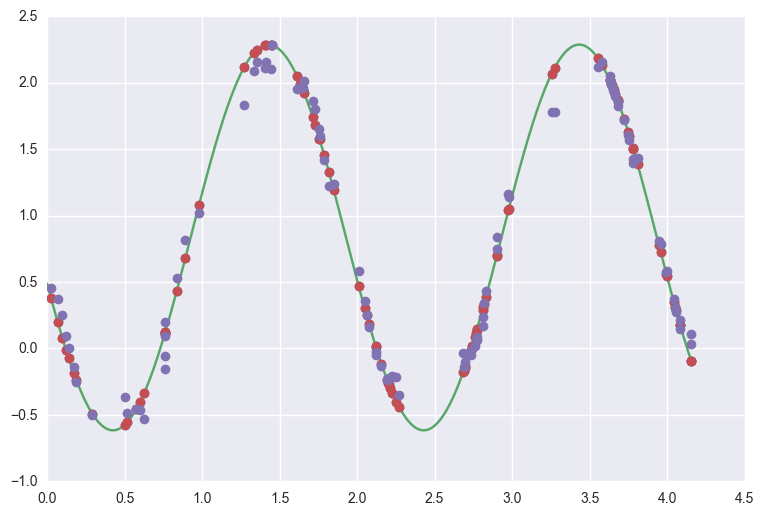

In [155]:
i += 1
if args.even:
    t = np.linspace(0, 2 * np.pi, X.shape[1])
    m = X[i, :, 0]
    pred_i = model.predict(X[[i]])[0, :, 0]
else:
    inds = (X[i, :, 0] >= 0.)
    t = X_raw[i, inds, 0]
    m = X[i, inds, 1]
#    e = X[i, inds, 2]
    plt.plot(t, m, 'o')
#    plt.errorbar(t, m, e, None, 'o')
    pred_i = model.predict({'main_input': X[i:i+1], 'aux_input': X[i:i+1, :, [0, ]]})[0, inds, 0]

T = np.linspace(0, t.max(), 501)
def sinusoid(p, A1, A2, b):
    return lambda t: A1 * np.cos(2 * np.pi / p * t) + A2 * np.sin(2 * np.pi / p * t) + b
    
plt.plot(T, sinusoid(*Y[i])(T))
plt.plot(t, m, 'o')
plt.plot(t, pred_i, 'o')

#w_r, A_r, phi_r, b_r = pred_gru[i]
#x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
#plt.plot(t, x_r, '--')

#plt.legend(['Noisy', 'Original'])

In [108]:
import glob
import os

log_files = glob.glob(os.path.join('keras_logs', 'autoencoder/uneven/noise0') + '/*.csv')
logs = [pd.read_csv(f, usecols=['Step', 'Value'], index_col='Step') for f in log_files]
for log, f in zip(logs, log_files):
#    log['Filename'] = f
    log.columns = [f[(f.rfind('-') + 1):f.rfind(',')] + ' ' + ('Validation' if 'val' in f else 'Training')]
all_logs = pd.concat(logs, axis=1)
all_logs.tail()

,gru_064_x2_5m04_drop25_emb64 Training,gru_064_x2_5m04_drop25_emb64 Validation,gru_064_x4_5m04_drop25_emb64 Training,gru_064_x4_5m04_drop25_emb64 Validation
Step,,,,
666,0.083600,0.056601,NaN,NaN
667,0.082556,0.046952,NaN,NaN
668,0.082574,0.051319,NaN,NaN
669,0.083550,0.050153,NaN,NaN
670,0.084179,0.053643,NaN,NaN


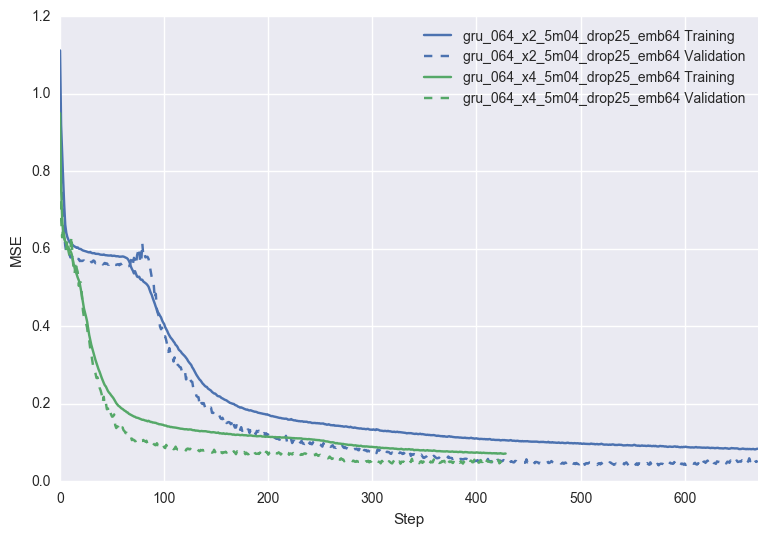

In [149]:
colors = sns.color_palette(n_colors=int(len(all_logs.columns) / 2))
for i, c in enumerate(all_logs.columns):
    all_logs[c].plot(color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
plt.ylabel('MSE');

In [ ]:
np.mean((m - pred_i) ** 2)

In [ ]:
S = np.corrcoef(encoding, Y[:encoding.shape[0]], rowvar=0)[:8, 8:]
print(pd.DataFrame(S))
plt.imshow(S, cmap='viridis', interpolation='none')
plt.colorbar()

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 0], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 1], Y[:encoding.shape[0], 1], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 2], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 3], Y[:encoding.shape[0], 3], kind='hex')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

model = RandomForestRegressor(n_estimators=128)
#model = ElasticNet()
#model = SVR(kernel='rbf')

model.fit(encoding, Y[:encoding.shape[0], 0])

In [ ]:
encoding_test = encode([X[test]])[0]
Y_pred = model.predict(encoding_test)

In [ ]:
#sns.jointplot(Y[test, 0], Y_pred[:, 0])
sns.jointplot(Y[test, 0], Y_pred)